# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('https://dc-edu.itmo.ru/assets/courseware/v1/8baa546c1c38f02f9ef2c11333112e89/asset-v1:ITMO+bonus_track_methods+2023+type@asset+block/titanic_train.csv')
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


Установите количество пропущенных значений поля <code>age</code>:

In [3]:
print('Количество пропущенных значений в age:', df['age'].isna().sum())

Количество пропущенных значений в age: 199


Определите долю выживших

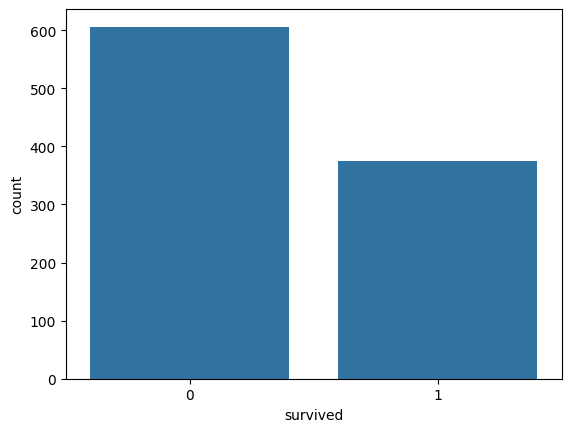

In [4]:
# построим гистограмму распределения объектов по классам
sns.countplot(df, x='survived')
plt.show()

In [5]:
# определим долю выживших
print('Доля выживших:', round(df['survived'].value_counts()[1]/len(df), 3))

Доля выживших: 0.382


Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [6]:
# удалим колонку ticket
df = df.drop(columns=['ticket'])

In [7]:
features = df.columns
features_to_remove = []

for feature in features:
  if df[feature].isna().sum() / len(df) > 0.3:
    features_to_remove.append(feature)

df = df.drop(columns=features_to_remove)
df

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,8.0500,S
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,8.0500,S
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,13.0000,S
979,3,0,"Barton, Mr. David John",male,22.0,0,0,8.0500,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [8]:
# заменим колонки sibsp и parch на колонку fam_size
df['fam_size'] = df.sibsp + df.parch
df = df.drop(columns=['sibsp', 'parch'])

In [9]:
# вычислим выборочное среднее колонки fam_size
print('Выборочное среднее колонки fam_size:', round(df['fam_size'].mean(), 3))

Выборочное среднее колонки fam_size: 0.866


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [10]:
print(f'Число предикторов: {len(df.columns) - 1}')

Число предикторов: 7


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [11]:
# оценим вероятность выжить если пассажир female и pclass = 2
print('Вероятность выжить:', round(df[(df['sex'] == 'female') & (df['pclass'] == 2)]['survived'].value_counts(normalize=True)[1], 3))

Вероятность выжить: 0.846


Постройте гистограммы выжиших и невыживших по возрастам.

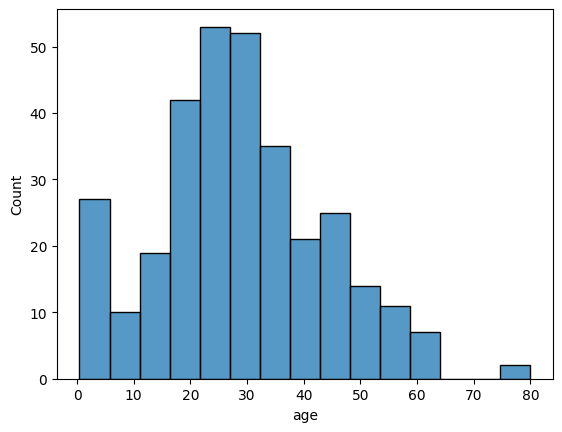

In [12]:
sns.histplot(df[df['survived'] == 1], x = 'age')
plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [13]:
# отберем только числовые признаки
numeric = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric]
df_numeric.head()

,pclass,survived,age,fare,fam_size
0,3,1,NaN,7.7333,0
1,3,1,NaN,7.7500,0
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0


In [14]:
# удалим строки, содержащие пропуски
df_numeric = df_numeric.dropna()

In [15]:
# разобьем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop(columns=['survived']), df_numeric['survived'], test_size=0.2, random_state=41, stratify=df_numeric['survived'])

print('Shapes', '   X', '     y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes    X      y
train (625, 4) (625,)
test  (157, 4) (157,)


In [16]:
# строим модель логистической регрессии
lr = LogisticRegression(random_state=41, max_iter=1000).fit(X_train, y_train)
prediction = lr.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.557


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [17]:
# отберем только числовые признаки
df_numeric = df[numeric]

In [18]:
# заполним пропуски средним
mis_replacer = SimpleImputer(strategy='mean')
df_numeric = pd.DataFrame(mis_replacer.fit_transform(df_numeric), columns=df_numeric.columns)

In [19]:
# разобьем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop(columns=['survived']), df_numeric['survived'], test_size=0.2, random_state=41, stratify=df_numeric['survived'])

print('Shapes', '   X', '     y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes    X      y
train (784, 4) (784,)
test  (197, 4) (197,)


In [20]:
# строим модель логистической регрессии
lr = LogisticRegression(random_state=41, max_iter=1000).fit(X_train, y_train)
prediction = lr.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.481


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [21]:
# отберем только числовые признаки и колонку name
numeric = df.select_dtypes(include=['number']).columns
df_numeric_name = pd.concat([df[numeric], df['name']], axis=1)
df_numeric_name.head()

,pclass,survived,age,fare,fam_size,name
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia"
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha"
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)"
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko"
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons"


In [22]:
# поместим значения обращений в колонку honorific
names = df_numeric_name['name']
honorific = []

for name in names:
  honor = name.split(', ')[1].split('.')[0]
  honorific.append(honor)

df_numeric_name['honorific'] = honorific
df_numeric_name.head()

,pclass,survived,age,fare,fam_size,name,honorific
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia",Miss
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha",Miss
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",Mrs
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko",Mr
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons",Mr


In [23]:
# вычислим число уникальных обращений
print('Число уникальных обращений:', len(df_numeric_name['honorific'].unique()))

Число уникальных обращений: 14


Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [24]:
# проверим, какие обращения были извлечены
print(df_numeric_name['honorific'].unique())

['Miss' 'Mrs' 'Mr' 'Master' 'Mlle' 'Rev' 'Ms' 'Col' 'Dona' 'Dr'
 'the Countess' 'Major' 'Don' 'Capt']


In [25]:
# сократим число обращений
df_numeric_name['honorific'] = df_numeric_name['honorific'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr')
df_numeric_name['honorific'] = df_numeric_name['honorific'].replace(['Dona', 'the Countess'], 'Mrs')
df_numeric_name['honorific'] = df_numeric_name['honorific'].replace(['Mlle', 'Ms'], 'Miss')

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [26]:
print('Доля строк со значением Master относительно числа всех мужчин:', round(len(df_numeric_name[df_numeric_name['honorific'] == 'Master']) / len(df[df['sex'] == 'male']), 3))

Доля строк со значением Master относительно числа всех мужчин: 0.072


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [27]:
# средний возраст категории Master
print('Средний возраст категории Master:', round(df_numeric_name[df_numeric_name['honorific'] == 'Master']['age'].mean(), 3))

Средний возраст категории Master: 5.128


Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [28]:
# посмотрим на средний возраст в зависимости от категории honorific
mean_age_by_honor = df_numeric_name.groupby('honorific')['age'].mean()
mean_age_by_honor

,age
honorific,
Master,5.128205
Miss,22.005765
Mr,32.900438
Mrs,36.984252


In [29]:
# заполним пропуски в колонке age средним, соответствующим среднему категории honorific
null_Master_id = df_numeric_name[(df_numeric_name['age'].isnull()) & (df_numeric_name['honorific'] == 'Master')].index
null_Miss_id = df_numeric_name[(df_numeric_name['age'].isnull()) & (df_numeric_name['honorific'] == 'Miss')].index
null_Mr_id = df_numeric_name[(df_numeric_name['age'].isnull()) & (df_numeric_name['honorific'] == 'Mr')].index
null_Mrs_id = df_numeric_name[(df_numeric_name['age'].isnull()) & (df_numeric_name['honorific'] == 'Mrs')].index

df_numeric_name.loc[null_Master_id, 'age'] = mean_age_by_honor[0]
df_numeric_name.loc[null_Miss_id, 'age'] = mean_age_by_honor[1]
df_numeric_name.loc[null_Mr_id, 'age'] = mean_age_by_honor[2]
df_numeric_name.loc[null_Mrs_id, 'age'] = mean_age_by_honor[3]

<ipython-input-29-146545becf71>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_numeric_name.loc[null_Master_id, 'age'] = mean_age_by_honor[0]
<ipython-input-29-146545becf71>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_numeric_name.loc[null_Miss_id, 'age'] = mean_age_by_honor[1]
<ipython-input-29-146545becf71>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_numeric_name.loc[null_Mr_id, 'age'] = mean_age_by_honor[2]
<

In [30]:
# проверим, все ли значения заполнены
df_numeric_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     981 non-null    int64  
 1   survived   981 non-null    int64  
 2   age        981 non-null    float64
 3   fare       981 non-null    float64
 4   fam_size   981 non-null    int64  
 5   name       981 non-null    object 
 6   honorific  981 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 53.8+ KB


In [31]:
# разобьем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_numeric_name.drop(columns=['survived', 'honorific', 'name']), df_numeric_name['survived'], test_size=0.2, random_state=41, stratify=df_numeric_name['survived'])

print('Shapes', '   X', '     y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes    X      y
train (784, 4) (784,)
test  (197, 4) (197,)


In [32]:
# строим модель логистической регрессии
lr = LogisticRegression(random_state=41, max_iter=1000).fit(X_train, y_train)
prediction = lr.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.485


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [33]:
# заполним пропуски колонки age в исходном наборе данных
df['age'] = df_numeric_name['age']

In [34]:
# удалим колонку name
df = df.drop(columns=['name'])

In [35]:
# произведем one-hot кодировние нечисловых признаков
non_numeric = df.select_dtypes(exclude=['number']).columns
dummies = pd.get_dummies(df[non_numeric], drop_first=True)
df = df.drop(columns=non_numeric)
df[dummies.columns] = dummies

In [36]:
# разобьем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['survived']), df['survived'], test_size=0.2, random_state=41, stratify=df['survived'])

print('Shapes', '   X', '     y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes    X      y
train (784, 7) (784,)
test  (197, 7) (197,)


In [37]:
# строим модель логистической регрессии
lr = LogisticRegression(random_state=41, max_iter=1000).fit(X_train, y_train)
prediction = lr.predict(X_test)

print(f'f1 score: {round(f1_score(y_test, prediction), 3)}')

f1 score: 0.676
